# Week 02 Lab: Machine Learning Basics

## Student Name: YOUR NAME HERE

## How long does it take for an object to fall to earth from a given height?

<img alt="newton-apple" src="http://3.bp.blogspot.com/-ex0MoQErWu8/U3jenn_DFMI/AAAAAAAAAUY/49lw-QXQyVM/s1600/philosophy-apple-newton.jpg" width="300"/>


On earth there is gravitational force:

$$
F_{grav} = mg
$$

where $m$ is the mass and $g = 9.81 m/s^2$.

In vacuum (which isn't very realistic) there is only gravitational force and the equations of motion are given as:

Total force:

$$
F = F_{grav}
$$

Acceleration:

$$
a = \frac{F}{m} = g
$$

Velocity after time $t$:

$$
v = at = gt
$$

Distance after time $t$:

$$
h = \frac{1}{2}at^2 = \frac{1}{2}gt^2
$$

We can solve this for the time it takes to fall from a given height:

$$
t = \sqrt{\frac{2h}{g}}
$$

We can plot time as a function of height based on this equation using `matplotlib`:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

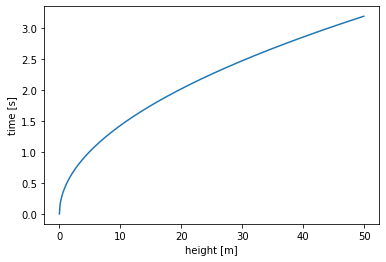

In [2]:
g=9.81
height=np.arange(0.0,50.0,0.1)
time=np.sqrt(2.0*height/g)

plt.plot(height,time)
plt.xlabel('height [m]')
plt.ylabel('time [s]')

#you can adjust the figure size if you like
#plt.rcParams["figure.figsize"] = (7,5)

plt.show()


## Can we learn this function from observational data?

<img alt="apple experiments" src="https://github.com/ADicksonLab/ml4md-jb/raw/main/Week-02/apple-experiment.png" width="400"/>

Here is a data set that was taken in vacuum:

[apple.vacuum.dat](https://raw.githubusercontent.com/ADicksonLab/ml4md-jb/main/Week-02/apple.vacuum.dat)

Please download this file to your local directory so that you can run the following part of the notebook.

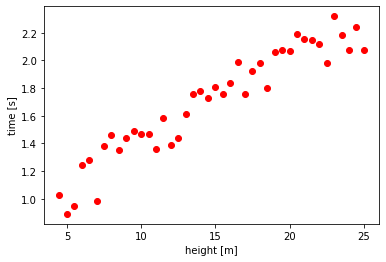

In [3]:
data=np.loadtxt('apple.vacuum.dat')
data_x=data[:,0]
data_y=data[:,1]

# note: 'ro' means 'red circles'
plt.plot(data_x,data_y,'ro')
plt.xlabel('height [m]')
plt.ylabel('time [s]')
plt.show()


## Training a neural network

In the following we will train a neural network using the data above. The goal is to develop a model that takes a height value as input and predicts the time it takes to hit the ground. We will train the model based on the (noisy) data shown above, but we will test it afterwards using the exact answer given by the equation above.

### Setting things up 

We will use `pytorch` for machine learning.

Please try the following to load the modules (and to check that the installation is fine):

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

If you get error messages above, you probably need to install `pytorch`. 

Try the following command if you are using a conda environment:

`conda install pytorch -c pytorch`

If you do not have a GPU (and no CUDA), try the following command instead:

`conda install pytorch cpuonly -c pytorch`


You can check for CUDA and the presence of GPUs with the following command (on Linux)

In [5]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


If it says 'command not found' or if there is another error message you probably do not have GPUs that can be used via CUDA.

If the package import did not succeed earlier, go back and try again after installing the pytorch package before proceeding.

### Preparing the data

We will begin by splitting the data into training and validation sets. This will be done with the following function:

In [6]:
import random

def randomsplitdata(fn,training_fraction):
    data=np.loadtxt(fn)
    
    tflag=np.zeros(len(data),dtype=int)
    while np.average(tflag)<training_fraction:
        tflag[random.randint(0,len(data)-1)]=1
    
    tdata=data[np.nonzero(tflag)].copy()
    vdata=data[np.nonzero(1-tflag)].copy()
    return tdata,vdata


Now we generate the training and validation sets. We need to specify what fraction of data should be the training set. In the example below it is set to 0.8 (i.e. 80%), but feel free to try out other values.

In [7]:
[training,validation]=randomsplitdata('apple.vacuum.dat',0.8) 

Next, we generate `Dataset` objects needed for `pytorch`. First we define a class:

In [8]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.label = data[:,1].astype(np.float32)
        self.input = data[:,0].reshape(-1,1)
    def __len__(self):
        return self.label.shape[0]
    def __getitem__(self, index):
        return self.input[index].astype(np.float32), self.label[index]

Now we use the class with the training and validation data sets generated above:

In [9]:
train_set=Dataset(training)
validation_set=Dataset(validation)

Using the data sets we set up data loader objects that are needed by `pytorch` for batch processing. Batches are only needed for the training data. The initial data here is small and we can choose small batch sizes, but for larger data sets, the batch size should be increased. A good choice for larger sets is 64 or 128.

In [10]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=1)

### Building a model

The neural network model is build as a class. 

In this case we are starting with the following architecture:

<img alt="newton-nn" src="https://github.com/ADicksonLab/ml4md-jb/raw/main/Week-02/newton-nn-model.png" width="400"/>

In [11]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # define layers to be used
        self.fc_1 = nn.Linear(1, 4)    # fully connected layer 1 -> 4 nodes
        self.fc_2 = nn.Linear(4, 4)    # fully connected layer 4 -> 4 nodes
        self.fc_f = nn.Linear(4, 1)    # fully connected layer 4 -> 1 nodes
    def forward(self, x):
        # back-propagation is done automatically
        x = F.relu(self.fc_1(x))       # run through first layer w/ ReLU activation
        x = F.relu(self.fc_2(x))       # run through second layer w/ ReLU activation
        x = self.fc_f(x)               # run through final layer w/o activation
        return x
    def initialize_weights(self, m):
        # initialization of weights, setting them to zero is not good
        if hasattr(m, 'weight') and m.weight.dim() > 1:
            nn.init.xavier_uniform_(m.weight.data)

### Training a model

First, we write training and validation functions. 

The `train` function returns the loss after going through an epoch (i.e. a number of batches to cover the training data). 

The `validate` function calculates the loss for the validation set so that we can determine when to stop the training.

The `do_training` function runs through a given number of epochs and returns the losses for the training and validation sets for further inspection.

In [12]:
def train(m,loss_fn,opt,loader):
    loss_sum = 0.0
    for input, label in loader:
        opt.zero_grad()
        
        #input = input.to("cuda")      # uncomment if CUDA/GPU platform available
        #label = label.to("cuda")      # uncomment if CUDA/GPU platofrm available
        
        output = m(input)              # this is where the model is evaluated
        
        output = torch.flatten(output)  
        loss = loss_fn(output, label)  # this is where the loss function is calculated
        loss.backward()                # this calculates the back-propagated loss
        loss_sum += loss.item()
        
        opt.step()                     # this carries out the gradient descent
    
    return loss_sum / len(loader)

def validate(m,loss_fn,loader):
    loss_sum = 0.0
    for input, label in loader:
        #input = input.to("cuda")     # if CUDA/GPU available
        #label = label.to("cuda")     # if CUDA/GPU available
        
        with torch.no_grad():
            output = m(input)
        
        output=torch.flatten(output)
        loss = loss_fn(output, label)
        loss_sum += loss.item()
    return loss_sum / len(loader)

def do_training(m,opt,tloader,vloader,epochs,output):
    # use MSE loss fucntion
    loss_fn = nn.MSELoss()
    
    tloss=np.zeros(epochs)
    vloss=np.zeros(epochs)

    for i in range(epochs):
        tloss[i] = train(m,loss_fn,opt,tloader)
        vloss[i] = validate(m,loss_fn,vloader)
        if (output):
            print (i, tloss[i], vloss[i])
            
    return tloss,vloss

We are now ready to train.

First, we create a **model instance**. Then we initialize the weights (randomly) and set the gradients to zero. 

Then we initialize an **optimizer**. There are two good optimizers: Adam and SGD. Choose one! The learning rate is set with `lr` and may need to be adjusted. The `weight_decay` rate adds regularization in the Aadm optimizer to avoid overfitting.

Then we run through 50 epochs to train the model. The output is the training data loss and the validation data loss.

In [13]:
model = Model()
#model.to("cuda")    # <--- uncomment this statement if you have CUDA and a GPU
model.apply(model.initialize_weights)
model.zero_grad()

print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.00001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.1)

print(optimizer)

epochs=50
showoutput=True

[training_loss,validation_loss]=do_training(model,optimizer,train_loader,validation_loader,epochs,showoutput)

Model(
  (fc_1): Linear(in_features=1, out_features=4, bias=True)
  (fc_2): Linear(in_features=4, out_features=4, bias=True)
  (fc_f): Linear(in_features=4, out_features=1, bias=True)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.005
    weight_decay: 1e-05
)
0 1.378403663635254 1.132428765296936
1 1.0932860771814983 0.8066406808793545
2 0.7328690687815348 0.5219953265041113
3 0.4774714907010396 0.30091321968939155
4 0.3650522530078888 0.16557758121052757
5 0.15037268896897635 0.11371070201857947
6 0.16099068025747934 0.09247798952856101
7 0.06720009609125555 0.08552479908559008
8 0.06533526256680489 0.08930377602416684
9 0.07314382493495941 0.08783123605098808
10 0.054540641605854034 0.08068813575664535
11 0.06533886988957723 0.061513508275311324
12 0.04741900414228439 0.05959793451148698
13 0.041885355177025 0.059639706301823026
14 0.03823556285351515 0.06531167510547675
15 0.05344352498650551 0.047952723617527226
16 0.0423349806418021

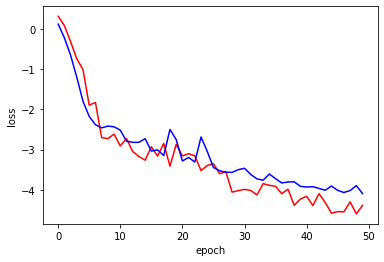

In [14]:
epoch_index=np.arange(epochs)
plt.plot(epoch_index,np.log(training_loss),color='r')
plt.plot(epoch_index,np.log(validation_loss),color='b')

plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()


### Testing the model

We now have a trained model that we can compare to the solution we know from physics

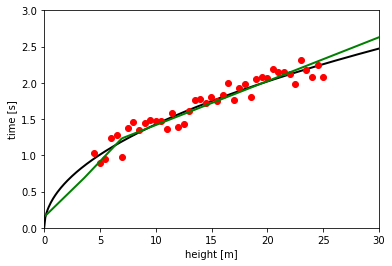

In [15]:
model_time=np.copy(height)
for i in range(len(model_time)):
    # this is ugly ... anybody know how to do this better?
    tval=torch.tensor([[height[i].astype(np.float32)]])
    model_time[i]=model(tval).item()

plt.plot(height,time,color='k',linewidth=2)
plt.plot(data_x,data_y,'ro')
plt.plot(height,model_time,color='g',linewidth=2)

plt.xlabel('height [m]')
plt.ylabel('time [s]')

plt.xlim([0,30])
plt.ylim([0,3.0])

plt.show()


What do you think about your first ML experiment?

### Exploring on your own

**TODO:** If you run again, how different is the solution? 
You should train multiple models with different training/validation data splits and obtain an average of the final loss to have a statistically meaningful result

**TODO:** Does training longer or changing the model improve accuracy?

**TODO:** Does changing optimizer parameters improve the speed of training?

**OPTION:** expand the notebook to calculate the loss with respect to the physics answer as the 'gold standard'.

### Using more data

Machine learning is expected to work better with more data.

Here is a much larger data set:

[apple.vacuum.highres.dat](https://raw.githubusercontent.com/ADicksonLab/ml4md-jb/main/Week-02/apple.vacuum.highres.dat)

Please also download this file to your local directory and check that you can plot the data:

In [ ]:
data_hr=np.loadtxt('apple.vacuum.highres.dat')
data_hr_x=data_hr[:,0]
data_hr_y=data_hr[:,1]

plt.plot(data_hr_x,data_hr_y,'ro',markersize=2)
plt.xlabel('height [m]')
plt.ylabel('time [s]')
plt.show()


Now, retrain your model from above. 

First prepare the data:

In [ ]:
[traininghr,validationhr]=randomsplitdata('apple.vacuum.highres.dat',0.8) 

train_hr_set=Dataset(traininghr)
validation_hr_set=Dataset(validationhr)

train_hr_loader = torch.utils.data.DataLoader(train_hr_set, batch_size=32, shuffle=True, num_workers=4)
validation_hr_loader = torch.utils.data.DataLoader(validation_hr_set, batch_size=1)

Then, run the training:

In [ ]:
model_hr = Model()
#model_hr.to("cuda")    # uncomment this statement if you have CUDA and a GPU
model_hr.apply(model_hr.initialize_weights)
model_hr.zero_grad()

optimizer_hr = torch.optim.Adam(model_hr.parameters(), lr=0.001, weight_decay=0.0001)

epochs=50
[training_hr_loss,validation_hr_loss]=do_training(model_hr,optimizer_hr,train_hr_loader,validation_hr_loader,epochs,True)

epoch_index=np.arange(epochs)
plt.plot(epoch_index,np.log(training_hr_loss),color='r')
plt.plot(epoch_index,np.log(validation_hr_loss),color='b')

plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

and inspect the results:

In [ ]:
model_hr_time=np.copy(height)

for i in range(len(model_hr_time)):
    tval=torch.tensor([[height[i].astype(np.float32)]])
    model_hr_time[i]=model_hr(tval).item()

plt.plot(height,time,color='k',linewidth=2)
plt.plot(data_hr_x,data_hr_y,'ro',markersize=2)

# original model in green
plt.plot(height,model_time,color='g',linewidth=2)

# highres model in blue
plt.plot(height,model_hr_time,color='b',linewidth=2)

plt.xlabel('height [m]')
plt.ylabel('time [s]')

plt.xlim([0,30])
plt.ylim([0,3.0])

plt.show()


Is it better?

### Exploring on your own

**TODO:** Build a new model with deeper layers (more layers and more nodes) and training again using the high-resolution data. For this you should create a new class (see template below that you can modify). 

In [ ]:
# modify to make more complex model!

class DeepModel(nn.Module):
    def __init__(self):
        super(DeepModel, self).__init__()
        # define layers to be used
        self.fc_1 = nn.Linear(1, 128)    # fully connected layer 1 -> 4 nodes
        self.fc_2 = nn.Linear(128, 128)    # fully connected layer 4 -> 4 nodes
        self.fc_3 = nn.Linear(128, 128)    # fully connected layer 4 -> 4 nodes
        
        self.fc_f = nn.Linear(128, 1)    # fully connected layer 4 -> 1 nodes
    def forward(self, x):
        # back-propagation is done automatically
        x = F.relu(self.fc_1(x))       # run through first layer w/ ReLU activation
        x = F.relu(self.fc_2(x))       # run through second layer w/ ReLU activation
        x = F.relu(self.fc_3(x))       # run through second layer w/ ReLU activation
        x = self.fc_f(x)               # run through final layer w/o activation
        return x
    def initialize_weights(self, m):
        # initialization of weights, setting them to zero is not good
        if hasattr(m, 'weight') and m.weight.dim() > 1:
            nn.init.xavier_uniform_(m.weight.data)

Let's train it:

In [ ]:
deepmodel = DeepModel()
#deepmodel.to("cuda")    # uncomment this statement if you have CUDA and a GPU
deepmodel.apply(deepmodel.initialize_weights)
deepmodel.zero_grad()

optimizer_deep = torch.optim.Adam(deepmodel.parameters(), lr=0.0002)

epochs=50

[training_deep_loss,validation_deep_loss]=do_training(deepmodel,optimizer_deep,train_hr_loader,validation_hr_loader,epochs,True)

epoch_index=np.arange(epochs)
plt.plot(epoch_index,np.log(training_deep_loss),color='r')
plt.plot(epoch_index,np.log(validation_deep_loss),color='b')

plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

In [ ]:
model_deep_time=np.copy(height)

for i in range(len(model_deep_time)):
    tval=torch.tensor([[height[i].astype(np.float32)]])
    model_deep_time[i]=deepmodel(tval).item()

plt.plot(height,time,color='k',linewidth=2)
plt.plot(data_hr_x,data_hr_y,'ro',markersize=1)
plt.plot(height,model_time,color='g',linewidth=2)
plt.plot(height,model_hr_time,color='b',linewidth=2)
plt.plot(height,model_deep_time,color='cyan',linewidth=4)

plt.xlabel('height [m]')
plt.ylabel('time [s]')

plt.xlim([0,30])
plt.ylim([0,3.0])

plt.show()


**TODO** Most of the models are not very good at 0 because there is no data, but we know that the time is 0 for an initial height of 0. Augment the training data by repeating 0,0 ten times (Why no just once?). Then try again using one of the models above.

In [ ]:
# This is how you add ONE extra data point:
# traininghr_augmented=np.concatenate((traininghr,[[0.0,0.0]]))

# you will then need to re-generate a new training data loader:
#train_aug_set=Dataset(traininghr_augmented)
#train_aug_loader = torch.utils.data.DataLoader(train_aug_set, batch_size=32, shuffle=True, num_workers=4)

**TODO** Build a new model with the augmented data and run the training again. Start by copying the notebook cells from above.

## OPTIONAL HOMEWORK

### Learning something useful

In reality, objects fall in air where there is a drag force that opposes the gravitational force. Becuase of the drag force there is a terminal velocity and lighter objects fall slower than heavier objects with the same cross-section exposed to air. The solution to this problem is not quite so straightforward because it involves solving a differential equation and it would be good to have a ML model for this problem.

Here is a data set for apples and leaves falling in air:

[apple.leaf.air.highres.dat](https://raw.githubusercontent.com/ADicksonLab/ml4md-jb/main/Week-02/apple.leaf.air.highres.dat)

Please also download this file to your local directory and check that you can plot the data.

In [ ]:
data_air=np.loadtxt('apple.leaf.air.highres.dat')
data_air_x=data_air[:,0]
data_air_y=data_air[:,1]

plt.plot(data_air_x,data_air_y,'ro',markersize=2)
plt.xlabel('height [m]')
plt.ylabel('time [s]')
plt.show()


There are two curves, one for apples, with the faster times, and one for leaves, with the slower times. Both data is in the same file. 

Data in the third column distinguishes whether a data point belongs to an apple ('1') or to a leaf ('2'):

In [ ]:
print(data_air[0])

Think about how you could modify the above training protocol to take not one but two input values (i.e. height and classification (apple/leaf)) to train a model that correctly predicts the time it takes to fall to the ground for either an apple or a leaf.

How would such a model work for predicting the time it takes for a branch to fall?

How could the model be improved to be more transferable to other objects?

**Additional notes:** 

The drag force that opposes the gravitational force is given as:

$$
F_{drag}=C_d \frac{\rho_{air}}{2} v^2 A
$$

$C_d$ is the drag coefficient (0.5 for a sphere, 2 for a flat plate) 

$\rho_{air}$ is $1.225 kg/m^3$ on the surface of the earth. 

$v$ is the velocity of an object falling through air. 

$A$ is the cross-sectional area of the object in the direction it falls.

The drag force has to be subtracted from the gravitational force to obtain the instantaneous acceleration:

$$
a = \frac{F_{grav}-F_{drag}}{m} = g - \frac{F_{drag}}{m}
$$

The velocity is then given as:

$$
\frac{dv}{dt} = a
$$

and distance is obtained from:

$$
\frac{dx}{dt} = v
$$

This gives the following differential equation to be solved:

$$
\frac{dx^2}{dt^2}-g+\frac{C_d}{m}\frac{\rho_{air}}{2}A\left(\frac{dx}{dt}\right)^2 = 0
$$
